In [1]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os

BUF_SIZE = 500
BATCH_SIZE = 20

In [2]:
# 用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(),
                         buf_size=BUF_SIZE),
    batch_size = BATCH_SIZE)

Cache file /home/akira/.cache/paddle/dataset/uci_housing/housing.data not found, downloading http://paddlemodels.bj.bcebos.com/uci_housing/housing.data 
Begin to download
............
Download finished


In [14]:
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  

In [3]:
train_data = paddle.dataset.uci_housing.train()
sample_data = next(train_data())
print(sample_data)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


In [4]:
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
y_predict = fluid.layers.fc(input=x, size=1, act=None)

In [5]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y)
avg_cost = fluid.layers.mean(cost)

In [7]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)
test_program = fluid.default_main_program().clone(for_test=True)

In [8]:
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

In [9]:
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

iter = 0
iters = []
train_costs = []

def draw_train_process(iters, train_cost):
    title = "training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs, color='red', label='training cost')
    plt.grid()
    plt.show()

In [22]:
EPOCH_NUM = 50
model_save_dir = '/home/akira/OpenAi/fit_a_line.inference.model'

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])

Pass:0, Cost:51.11959
Pass:1, Cost:67.91682
Pass:2, Cost:86.67586
Pass:3, Cost:90.52480
Pass:4, Cost:27.09834
Pass:5, Cost:106.38853
Pass:6, Cost:18.84369
Pass:7, Cost:111.28500
Pass:8, Cost:104.89248
Pass:9, Cost:59.42886
Pass:10, Cost:64.40924
Pass:11, Cost:82.75085
Pass:12, Cost:51.26777
Pass:13, Cost:26.44215
Pass:14, Cost:17.41399
Pass:15, Cost:20.57138
Pass:16, Cost:120.36810
Pass:17, Cost:47.11916
Pass:18, Cost:112.35677
Pass:19, Cost:81.49672
Pass:20, Cost:52.80754
Pass:21, Cost:47.66893
Pass:22, Cost:14.91515
Pass:23, Cost:52.42912
Pass:24, Cost:101.30814
Pass:25, Cost:59.61827
Pass:26, Cost:31.15186
Pass:27, Cost:96.80831
Pass:28, Cost:61.58362
Pass:29, Cost:96.22063
Pass:30, Cost:79.76251
Pass:31, Cost:97.89824
Pass:32, Cost:44.62197
Pass:33, Cost:27.90074
Pass:34, Cost:29.31424
Pass:35, Cost:59.29298
Pass:36, Cost:47.84963
Pass:37, Cost:33.02017
Pass:38, Cost:28.58389
Pass:39, Cost:67.11362
Pass:40, Cost:16.42882
Pass:41, Cost:41.62553
Pass:42, Cost:41.32171
Pass:43, Cost:2

Test:49, Cost:1.76166
Save models to /home/akira/OpenAi/fit_a_line.inference.model .


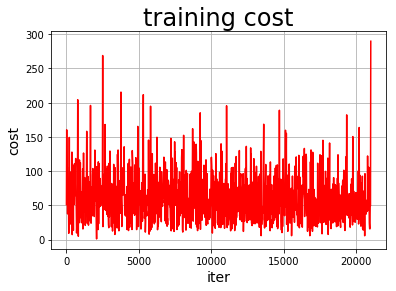

In [23]:
# 开始测试并输出最后一个batch的损失值
test_cost = 0
for batch_id, data in enumerate(test_reader()):
    test_cost = exe.run(program=test_program,
                       feed=feeder.feed(data),
                       fetch_list=[avg_cost])
print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))

if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print("Save models to %s ." % (model_save_dir))

fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_cost)

In [24]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [31]:
infer_exe = fluid.Executor(place)
interfence_scope = fluid.core.Scope()

infer_results = []
groud_truths = []

def draw_infer_result(ground_truths, infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

infer results: (House Price)
0: 13.94
1: 14.15
2: 13.83
3: 15.95
4: 14.67
5: 15.36
6: 14.30
7: 14.33
8: 11.47
9: 14.20
10: 10.62
11: 12.87
12: 13.72
13: 13.04
14: 12.68
15: 14.32
16: 15.86
17: 15.68
18: 16.02
19: 13.92
20: 14.66
21: 13.07
22: 15.27
23: 14.45
24: 14.51
25: 13.78
26: 15.22
27: 15.11
28: 16.23
29: 14.97
30: 14.68
31: 14.02
32: 14.04
33: 12.67
34: 12.25
35: 14.93
36: 14.97
37: 15.69
38: 15.94
39: 15.76
40: 14.07
41: 13.48
42: 15.55
43: 15.96
44: 15.86
45: 15.43
46: 14.41
47: 16.06
48: 16.17
49: 16.69
50: 14.22
51: 14.60
52: 13.92
53: 14.20
54: 15.85
55: 16.52
56: 15.90
57: 16.64
58: 16.78
59: 17.18
60: 17.39
61: 17.09
62: 14.52
63: 15.78
64: 16.63
65: 17.33
66: 17.03
67: 17.53
68: 17.59
69: 18.11
70: 15.80
71: 15.32
72: 16.59
73: 14.67
74: 16.24
75: 16.94
76: 18.29
77: 18.73
78: 18.98
79: 18.56
80: 17.92
81: 18.40
82: 17.20
83: 17.96
84: 17.70
85: 16.64
86: 15.68
87: 17.90
88: 18.78
89: 22.57
90: 22.76
91: 22.43
92: 20.99
93: 22.08
94: 22.44
95: 21.74
96: 22.01
97: 23.65
9

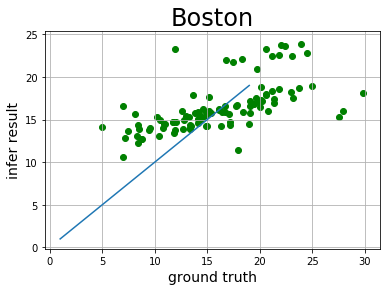

In [32]:
with fluid.scope_guard(interfence_scope):
    [inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(model_save_dir, infer_exe)
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),
                               batch_size=200)
    
    test_data = next(infer_reader())
    text_x = np.array([data[0] for data in test_data]).astype("float32")
    text_y = np.array([data[1] for data in test_data]).astype("float32")
    
    results = infer_exe.run(inference_program,
                           feed={feed_target_names[0]: np.array(text_x)},
                           fetch_list=fetch_targets)
    
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(text_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)